In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Linear regression: a tutorial
### James Hensman 2017

##  Maximum likelihood linear regression

Probably the most basic model in statistics is linear regression. We're given some data in the form of input-output pairs $(x_i, y_i)$, and we're asked "what can you tell me about the value of $y$ at a new $x$?", and as the simplest model we assume a linear relationship between input and output.

In python, we stack the pairs into numpy arrays like this:

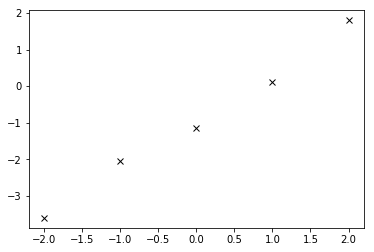

In [2]:
# let's make up a very simple dataset
x_list = [-2, -1, 0, 1, 2]
X = np.array(x_list).reshape(-1, 1)  # note the shape convention
# this makes it easier to generalise the code to multiple dimensions
y_list = [-3.6, -2.05, -1.15, 0.1, 1.8]
Y = np.array(y_list).reshape(-1, 1)  # note the shape convention

plt.plot(X, Y, 'kx')

The linear relationship between input and output is described by the function

$f(x) = ax + b$,

and we want to find the parameters $(a, b)$ in this equation.

In maximum likelihood linear regression, they are determined by maximising the likelihood $p(y \,|\, a, b)$ under the formulation

$y_i = f(x_i) + \epsilon_i$

with

$\epsilon_i \sim \mathcal N(0, \sigma_n^2)$.

This leads to the same result as "least squares regression", and this is sometimes called "the line of best fit".


If we were doing "deep learning" we would make $f$ a much more complicated function, and then try to find some suitable parameters by gradient descent.
In linear regression, though, there's actually a closed form solution!

This is facilitated by the following two functions:

In [3]:
def linear_features(X):
    """
    Creates a feature matrix for linear regression
    """
    return np.hstack([X, np.ones((X.shape[0], 1))])

def ml_linear_regression(X, Y, features):
    """
    Returns the maximum likelihood parameters for linear regression
    """
    Phi = features(X)
    return np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, Y))

#### Ex. 1. 

a) Use the above functions to estimate the parameters $(a, b)$. Do they seem sensible?

b) What is the ML prediction for $f(0.5)$?

c) Plot the maximum likelihood straight line through the data

d) Why does `linear_features` add a column of ones to the data?

e) (advanced) What happened to $\sigma_n^2$? Why doesn't if affect the answer?

f) (advanced) Derive the expression we've used for the ML estimator.

In [ ]:
# Your answers here. 

# For help with the notebook, click on the "Help" menu, press [F1] or type "ctrl-m h". 
# For help with understanding, ask a PM team member!

## Bayesian Linear regression

We saw in the lecture that Bayesian linear regression means starting from a prior distribution over functions and moving to a posterior distribution. In this section we'll examine some functions under the prior and posterior distributions.



### Draws from the prior

Since we have two parameters, we need a two-dimensional prior distribution. Here we use the multivariate normal distribution, which is defined by the mean vector $\boldsymbol \mu_0$ and the covariance matrix $\mathbf \Sigma_0$.
In maths we write

$p(\boldsymbol \theta) = \mathcal N(\boldsymbol \mu_0,\, \mathbf \Sigma_0)$.

A sensible prior distribution is:

In [ ]:
mu_0 = np.zeros((2, 1))
Sigma_0 = np.eye(2)

Here are some helper functions:

In [ ]:
def sample_theta(mu, Sigma):
    """
    For a given distribution, sample a vector for theta
    """
    sample = mu + np.dot(np.linalg.cholesky(Sigma), np.random.randn(mu.size, 1))
    return sample

def plot_linear_function(theta, lower=-3, upper=3):
    """
    Plot a linear function with parameters theta over the range (lower, upper)
    """
    Xtest = np.linspace(lower, upper, 200).reshape(-1, 1)
    Phi = linear_features(Xtest)
    f = np.dot(Phi, theta)
    plt.plot(Xtest, f)

#### Ex. 2
a) Use (maybe modify?) the above helper functions to plot 10 samples from the prior on the same figure.

b) Change the prior. Can you interpret what happens by plotting? For example, try `Sigma_0 = np.array([[1., 0], [0, 0.001]])`

In [ ]:
# Your answers here.

### Draws from the posterior

Much like maximum likelihood linear regression, Bayesian linear regression has a closed form. Here's a helper:


In [ ]:
def bayesian_linear_regression(X, Y, features, mu_0, Sigma_0, sigma_n):
    """
    Returns the posterior distribution (mu_p, Sigma_p) 
    of the parameters theta in Bayesian linear regression
    """
    precision = np.linalg.inv(Sigma_0)
    Phi = features(X)
    
    Sigma_p = np.linalg.inv(precision + np.dot(Phi.T, Phi) / sigma_n ** 2)
    mu_p = np.dot(Sigma_p, np.dot(precision, mu_0 + np.dot(Phi.T, Y) / sigma_n **2))
    
    return mu_p, Sigma_p

#### Ex. 3.
a) Improve the docstring in `bayesian_linear_regression` by adding type annotation :p

b) Compute the posterior distribution for our tiny dataset. What's the relationship between `mu_p` and the maximum-likelihood estimate?

c) Draw and plot 100 functions from the posterior.

d) How can we pick a sensible value for $\sigma_n$?

e) What would happen if we had more (or fewer) data? Generate your own dataset and find out.

In [ ]:
# Your answers here.

## Linear regression with non-linear basis functions

Linear regression can approximate nonlinear functions using nonlinear basis functions. It's still called linear regression because the relationship between the output and the *_basis_* is linear, even though the relationship between the output and the *input* might not be.
How can we use this stuff to learn nonlinear functions? The usual answer is to project the problem into some features space. Don't worry if that sounds hard: we just have to replace the `linear_features` function above, and we'll be rollin'.


### Radial Basis Function networks
Radial basis function networks is a "neural network" that is actually just linear regression on some flexible features. The form of the features is:

$\phi_i(x) = \exp(-(x - c_i) / \ell^2)$,

where the parameters $c_i$ are so-called 'centers' of the radial basis functions (we will assume them to be located on a regular grid), and $\ell$ is the width. Here's a simple implementation.

In [ ]:
class RBFFeatures(object):
    def __init__(self, centers, width):
        self.centers, self.width = centers, width
    def __call__(self, X):
        return np.exp(-np.square((X - self.centers) / self.width))

To illustrate this model, we're going to need a more interesting dataset. Here's one:

In [ ]:
X = np.sort(np.random.rand(100)).reshape(-1,1)
Y = np.sin(18 * X) + 2.5 * np.cos(5 * X) + 0.5 * np.random.randn(*X.shape)
plt.plot(X, Y, 'kx')

Here's a sensible but rather arbitrary set of features and a prior distribution for the parameters.

In [ ]:
N_centers = 5
c = np.linspace(0, 1, N_centers)
width = 0.1
f = RBFFeatures(c, width)

mu_0 = np.zeros((10, N_centers))
Sigma_0 = np.eye(N_centers)

#### Ex. 4

a) Can you plot a sample from this prior? What happens to the functions away from the centers?

b) Compute the posterior and plot some sample functions. (hint: try `sigma_n = 0.5`)

c) What happens to the *posterior* functions away from the centers?

d) What is the effect of using more / fewer basis functions?

e) What is the effect of the width parameter? 

f) How on earth are we going to set all of these parameters??!?

g) (advanced) Can the fit be improved by optimizing the location of the basis functions?